In [1]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from biodatatools.utils.common import json_load
from scipy.stats import pearsonr
from statannotations.Annotator import Annotator
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
import sys
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9
lw = 0.8

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"

# Correlation between metastatic cancers and normal tissue samples

In [4]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")

In [5]:
n_samples = list(pd.read_table(f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt", header=None)[0])
m_samples = groups["metastatic_cancer"]
all_samples = n_samples + m_samples
len(n_samples), len(m_samples)

(93, 23)

In [6]:
p = "divergent"
ds = ["distal", "proximal"]

In [7]:
df_exp = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/norm_reads_vst_all.txt", index_col=0)
dfs = {}
for d in ds:
    df_binary = pd.read_table(f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt", index_col=0)
    es = list(df_binary[df_binary[all_samples].sum(axis=1) >= 1].index)
    dfs[d] = df_exp[all_samples].loc[es]

In [18]:
pcs = {}
for d in dfs:
    pca = PCA(n_components=0.9, random_state=42)
    data = pca.fit_transform(dfs[d].T)
    pcs[d] = pd.DataFrame(data, index=all_samples)

In [23]:
sites = {"Breast": ["Brain", "Ovary"],
         "Large intestine": ["Lung", "Brain"],
         "Liver": ["Adrenal gland", "Lung"],
         "Lung": ["Adrenal gland"],
         "Pancreas": ["Ovary"]
        }

In [11]:
hue_order = ["Anatomically distinct sites", 
             "Metastatic site", 
             "Primary site"]

In [28]:
pairs = defaultdict(list)
for s in m_samples:
    psite, msite = labels[s]
    msite = "Brain" if "Brain" in labels[s][1] else labels[s][1]
    pairs[(psite, msite, hue_order[0])].extend([(s,s2) for s2 in n_samples if labels[s2][1] not in [psite, msite]])
    pairs[(psite, msite, hue_order[1])].extend([(s,s2) for s2 in n_samples if labels[s2][1] == msite])
    pairs[(psite, msite, hue_order[2])].extend([(s,s2) for s2 in n_samples if labels[s2][1] == psite])

In [29]:
results = []
for psite, msite, k in pairs:
    for s1, s2 in pairs[(psite, msite, k)]:
        for d in ds:
            arr1 = pcs[d].loc[s1].values
            arr2 = pcs[d].loc[s2].values
            corr, pval = pearsonr(arr1, arr2)
            results.append([d, s1, f"{psite} \u2192 {msite}", s2, k, corr, pval])
df_corr = pd.DataFrame(results, columns=["Group", "Met sample", "Metastatic route", "Ref sample", "Site", "Correlation", "Pvalue"])
df_corr.head(2)

,Group,Met sample,Metastatic route,Ref sample,Site,Correlation,Pvalue
0,distal,BCT10,Breast → Ovary,B1,Anatomically distinct sites,-0.114429,0.443746
1,proximal,BCT10,Breast → Ovary,B1,Anatomically distinct sites,-0.146952,0.372009


In [30]:
def plot_corr(d, figsize, outputfile):
    fig, ax = plt.subplots(figsize=figsize)
    df = df_corr[df_corr["Group"]==d]
    hue_plot_params = {"data": df,
                        "x": "Correlation",
                        "y": "Metastatic route",
                        "hue": "Site",
                        "orient": 'h',
                        "order": [f"{psite} \u2192 {msite}" for psite in sites for msite in sites[psite]], 
                        "hue_order": hue_order,
                        "palette": ["#d9d9d9", "#b3de69", "#31a354"],
                        "showfliers": False
                        }
    g = sns.boxplot(ax=ax, **hue_plot_params)
    g.spines[["top", "right"]].set_visible(False)

    if d == "distal":
        g.legend([],[],frameon=False)
        g.set_title("Metastatic cancer vs non-neoplastic tissue", fontsize=bfontsize, x=0)
    else:
        g.legend(loc="upper center", title=None, fontsize=sfontsize, bbox_to_anchor=(0.5,1.22), frameon=False)
        g.text(
            0.15, 1.1,
            "Metastatic cancer vs\nnon-neoplastic tissue from:",
            fontsize=bfontsize,
            ha="right",
            va="center",
            transform=ax.transAxes
        )
    
    g.set_ylabel("Metastatic cancer\n(Primary \u2192 metastatic site)", fontsize=bfontsize, labelpad=18)
    line_x = -0.9 if d == "distal" else -0.5
    g.plot([line_x, line_x], [0, 1], transform=g.transAxes, color='black', clip_on=False, lw=lw)
    
    g.set_xlabel("Correlation", fontsize=bfontsize)
    g.set_xlim([-0.7,1.1])
    
    g.tick_params(labelsize=sfontsize)

    pas = []
    for t in set(df["Metastatic route"]):
        pas.extend([[(t, hue_order[0]), (t, hue_order[1])], [(t, hue_order[1]), (t, hue_order[2])]])
    annotator = Annotator(g, pas, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", text_format="star", correction_format="replace",
                        comparisons_correction="BH", verbose=False, line_width=lw, fontsize=sfontsize)
    annotator.apply_and_annotate()
    
    plt.savefig(outputfile, bbox_inches="tight", transparent=True)

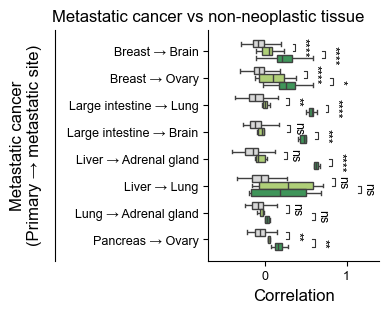

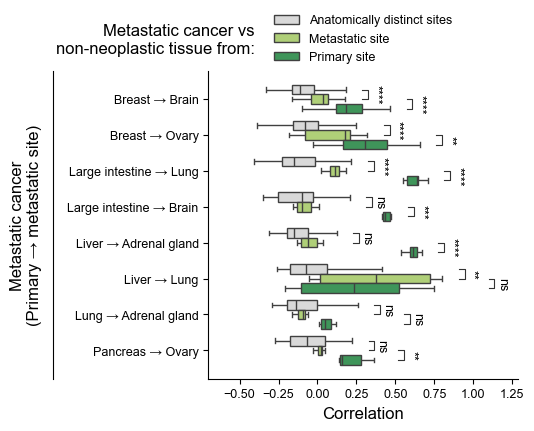

In [31]:
for d in ds:
	figsize = (2.2,3) if d == "distal" else (4,4)
	outputfile = f"{PROJECT_DIR_o}figures/Fig6c.pdf" if d == "distal" else f"{PROJECT_DIR_o}figures/SuppFig10a.pdf"
	plot_corr(d, figsize, outputfile)

# Hierarchical clustering

In [29]:
# Metastatic samples whose primary site are large intestine + normal samples at corresponding primary and metastatic sites

mets = ["Lung", "Brain"]
CRC_met_norm_samples = [s for s in m_samples if labels[s][0] == "Large intestine"] + [s for s in n_samples if labels[s][1] in ["Large intestine", "Lung", "Brain"]]
len(CRC_met_norm_samples)

16

In [37]:
d = "distal"
Z = sch.linkage(pcs[d].loc[CRC_met_norm_samples], metric='euclidean', method='ward')

In [45]:
labs = []
for s in CRC_met_norm_samples:
	if s in m_samples:
		psite, msite = labels[s]
		labs.append(f"{psite} \u2192 {msite}  ({s})")
	else:
		labs.append(f"{labels[s][1]} ({s})")

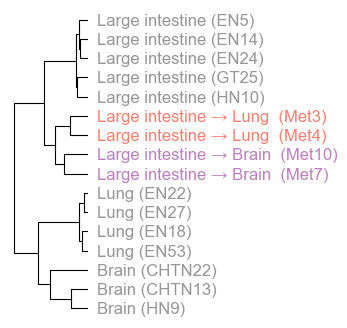

In [52]:
fig, ax = plt.subplots(figsize=(1,4))
dendro = sch.dendrogram(Z, labels=labs, leaf_rotation=0, orientation="left", 
						color_threshold=0, link_color_func=lambda k: "black")
for line in ax.collections:
	line.set_linewidth(lw)

ax.spines[['top','bottom','left', 'right']].set_visible(False)
ax.xaxis.set_visible(False)

ax.invert_yaxis()
for label in ax.get_yticklabels():
	text = label.get_text()
	label.set_fontsize(bfontsize)
	if "\u2192 Lung" in text:
		label.set_color("#fb8072") 
	elif "\u2192 Brain" in text:
		label.set_color("#bc80bd") 
	else:
		label.set_color("#969696") 
		
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig10a.pdf", bbox_inches='tight', transparent=True)